# Analysis of signal characteristics and signal overlaps
Here, the signal train lengths and  the inter-pulse/vibration intervals are calculated and plotted. Additionally, the overlap between signal types is quantified and an example plot is created. 

Author: Bjarne Schultze <br>
Last modified: 29.11.2024

In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from pdf2image import convert_from_path

import modules.analysis_utils as utils
import modules.plotting_utils as myplt
import modules.data_handling_utils as dutils

plt.style.use('./plotstyle_bjarne.mplstyle')

### Preparation

In [2]:
main_path = "E:/res/"
metadata_path = "./accessory_files/metadata.pkl"

# Define colors
vib_col = to_rgb("#46A81F")   # '#46A81F'
pulse_col = to_rgb("#ff0000")  # '#5D11AD' 
sine_col = to_rgb("#2d7cff")  # '#F07236'  
cmap = ListedColormap([np.array([1.0,1.0,1.0]),sine_col,pulse_col,vib_col])

# Load metadata file (first five files with different protocol are missing)
metadata = pd.read_pickle(metadata_path)

In [3]:
# Choose an experimental group
exp_grp = "TN1A" 
# Create a dictionary mapping experimental group and genotype in the meta data table
genotype_dict = {"pIP10": "CsChrimson; VT40556", "TN1A": "TN1A_CsChrimson", "vPR13": "vPR13_CsChrimson", 
                 "vMS12-SS3": "vMS12-SS3_CsChrimson", "CsChrimson_ctrl": "CsChrimson", "vPR13_ctrl": "vPR13"}

exp = metadata.loc[metadata["genotype"] == genotype_dict[exp_grp], :]
experiments = exp.loc[exp["individuals.1"].isna(), "filename"].to_list()
experiments_mf = exp.loc[exp["individuals.1"] == "1", "filename"].to_list()

In [4]:
# Read the calibration table for the light intensity
if exp_grp == "pIP10":    # For the pIP10 protocol
    with open("./accessory_files/opto_calibration_120_5.txt") as f:
        lines = f.readlines()
    opto_calib = np.sort(np.array([ txt.removesuffix('\n').split(',') for txt in lines ]).astype('float'), axis=0)
else:       # For the normal protocol (all other conditions)
    with open("./accessory_files/opto_calibration_26_4.txt") as f:
        lines = f.readlines()
    opto_calib = np.sort(np.array([ txt.removesuffix('\n').split(',') for txt in lines ]).astype('float'), axis=0)

In [5]:
# Load the annotations for the male-female and solitary condition
annotations_mf, stim_ons_mf, stim_offs_mf, stim_volts_mf, bad_files = dutils.load_annotations(experiments_mf, main_path=main_path, metadata_path=metadata_path)
annotations, stim_ons, stim_offs, stim_volts, _ = dutils.load_annotations(experiments, main_path=main_path, metadata_path=metadata_path)

# Set a bin width
bin_width = 0.1    # [s]
# Calculate the stimulus length
stim_len = stim_offs[0][0] - stim_ons[0][0]

# Set the sampling rate
sampling_rate = 10000

Skipped experiment localhost-20240325_085619! Incomplete stimulus set before copulation.
Skipped experiment localhost-20240325_093502! Incomplete stimulus set before copulation.


In [ ]:
# Create raster matrices with fine time resolution
full_hist_p_mf_fine, hist_edges_mf_fine = utils.psth(annotations_mf, stim_ons_mf, stim_len, 
                                                     event_label='pulse_manual', bin_width=10/sampling_rate, output='full')
full_hist_v_mf_fine, _ = utils.psth(annotations_mf, stim_ons_mf, stim_len, event_label='vibration_manual', 
                                    bin_width=10/sampling_rate, output='full')
full_hist_s_mf_fine, _ = utils.psth(annotations_mf, stim_ons_mf, stim_len, event_label='sine_manual', 
                                    bin_width=10/sampling_rate, output='full')

full_hist_p_fine, hist_edges_fine = utils.psth(annotations, stim_ons, stim_len, event_label='pulse_manual', 
                                               bin_width=10/sampling_rate, output='full')
full_hist_v_fine, _ = utils.psth(annotations, stim_ons, stim_len, event_label='vibration_manual', 
                                 bin_width=10/sampling_rate, output='full')
full_hist_s_fine, _ = utils.psth(annotations, stim_ons, stim_len, event_label='sine_manual', 
                                 bin_width=10/sampling_rate, output='full')

### Find trains of a signal type


In [ ]:
# For pulse
ptrain_start, ptrain_stop, ptrain_len = utils.find_evt_trains_multi(full_hist_p_fine, hist_edges_fine[:-1], 60)
ptrain_start_mf, ptrain_stop_mf, ptrain_len_mf = utils.find_evt_trains_multi(full_hist_p_mf_fine, hist_edges_mf_fine[:-1], 60)
# For sine
strain_start, strain_stop, strain_len = utils.find_evt_trains_multi(full_hist_s_fine, hist_edges_fine[:-1], 1.1)
strain_start_mf, strain_stop_mf, strain_len_mf = utils.find_evt_trains_multi(full_hist_s_mf_fine, hist_edges_mf_fine[:-1], 1.1)
# For vibration
vtrain_start, vtrain_stop, vtrain_len = utils.find_evt_trains_multi(full_hist_v_fine, hist_edges_fine[:-1], 300)
vtrain_start_mf, vtrain_stop_mf, vtrain_len_mf = utils.find_evt_trains_multi(full_hist_v_mf_fine, hist_edges_mf_fine[:-1], 300)


### Find the overlap between pulse-vibration and sine-vibration
# Allocate lists to collect the potential overlap between vibration and pulse/sine
vp_overlap = []
vs_overlap = []
vp_overlap_mf = []
vs_overlap_mf = []
vp_overlap_tp = []
vs_overlap_tp = []

# Iterate over the trials (rows of the full hist matrix)
for i in range(full_hist_p_fine.shape[0]):
    if ptrain_start[i].shape[0] > 0 and vtrain_start[i].shape[0] > 0:
        # Find potential overlaps between the signal types
        vp_overlap.append(utils.overlap(ptrain_start[i], ptrain_stop[i], vtrain_start[i], vtrain_stop[i]))
    else:
        vp_overlap.append(np.array([]))

    if strain_start[i].shape[0] > 0 and vtrain_start[i].shape[0] > 0:
        # Find potential overlaps between the signal types
        vs_overlap.append(utils.overlap(strain_start[i], strain_stop[i], vtrain_start[i], vtrain_stop[i]))
    else:
        vs_overlap.append(np.array([]))

# Iterate over the trials (rows of the full hist matrix)
for i in range(full_hist_p_mf_fine.shape[0]):
    if ptrain_start_mf[i].shape[0] > 0 and vtrain_start_mf[i].shape[0] > 0:
        # Find potential overlaps between the signal types
        vp_overlap_mf.append(utils.overlap(ptrain_start_mf[i], ptrain_stop_mf[i], vtrain_start_mf[i], vtrain_stop_mf[i]))
    else:
        vp_overlap_mf.append(np.array([]))

    if strain_start_mf[i].shape[0] > 0 and vtrain_start_mf[i].shape[0] > 0:
        # Find potential overlaps between the signal types
        vs_overlap_mf.append(utils.overlap(strain_start_mf[i], strain_stop_mf[i], vtrain_start_mf[i], vtrain_stop_mf[i]))
    else:
        vs_overlap_mf.append(np.array([]))

### Split the overlaps between pre-stimulation and stimulation-time and sum the times


In [ ]:
# Split in pre and during stimulation
total_overlap_vs_mf_dur = [ np.diff(i, axis=1) for i in vs_overlap_mf if i.size > 0 and i[0][0] > 0 ]
total_overlap_vs_mf_pre = [ np.diff(i, axis=1) for i in vs_overlap_mf if i.size > 0 and i[0][0] < 0 ]
# Sum the overlap times
if len(total_overlap_vs_mf_dur) > 0: total_overlap_vs_mf_dur = np.concatenate(total_overlap_vs_mf_dur).sum().round(3)
if len(total_overlap_vs_mf_pre) > 0: total_overlap_vs_mf_pre = np.concatenate(total_overlap_vs_mf_pre).sum().round(3)

# Repeat for pulse-vibration overlap
total_overlap_vp_mf_dur = [ np.diff(i, axis=1) for i in vp_overlap_mf if i.size > 0 and i[0][0] > 0 ]
total_overlap_vp_mf_pre = [ np.diff(i, axis=1) for i in vp_overlap_mf if i.size > 0 and i[0][0] < 0 ]

if len(total_overlap_vp_mf_dur) > 0: total_overlap_vp_mf_dur = np.concatenate(total_overlap_vp_mf_dur).sum().round(3)
if len(total_overlap_vp_mf_pre) > 0: total_overlap_vp_mf_pre = np.concatenate(total_overlap_vp_mf_pre).sum().round(3)


# Repeat for solitary condition
total_overlap_vs_dur = [ np.diff(i, axis=1) for i in vs_overlap if i.size > 0 and i[0][0] > 0 ]
total_overlap_vs_pre = [ np.diff(i, axis=1) for i in vs_overlap if i.size > 0 and i[0][0] < 0 ]

if len(total_overlap_vs_dur) > 0: total_overlap_vs_dur = np.concatenate(total_overlap_vs_dur).sum().round(3)
if len(total_overlap_vs_pre) > 0: total_overlap_vs_pre = np.concatenate(total_overlap_vs_pre).sum().round(3)

total_overlap_vp_dur = [ np.diff(i, axis=1) for i in vp_overlap if i.size > 0 and i[0][0] > 0 ]
total_overlap_vp_pre = [ np.diff(i, axis=1) for i in vp_overlap if i.size > 0 and i[0][0] < 0 ]

if len(total_overlap_vp_dur) > 0: total_overlap_vp_dur = np.concatenate(total_overlap_vp_dur).sum().round(3)
if len(total_overlap_vp_pre) > 0: total_overlap_vp_pre = np.concatenate(total_overlap_vp_pre).sum().round(3)

# Print the results
print(f"""Overlaps (m) ------\n 
 Vib-sine (starting < 0 s):\t {total_overlap_vs_pre} s 
 Vib_sine (starting > 0s):\t {total_overlap_vs_dur} s
 Vib-pulse (starting < 0 s):\t {total_overlap_vp_pre} s 
 Vib_pulse (starting > 0s):\t {total_overlap_vp_dur} s\n
Overlaps (mf) ------\n 
 Vib-sine (starting < 0 s):\t {total_overlap_vs_mf_pre} s 
 Vib_sine (starting > 0s):\t {total_overlap_vs_mf_dur} s
 Vib-pulse (starting < 0 s):\t {total_overlap_vp_mf_pre} s 
 Vib_pulse (starting > 0s):\t {total_overlap_vp_mf_dur} s""")

Overlaps (m) ------
 
 Vib-sine (starting < 0 s):	 [] s 
 Vib_sine (starting > 0s):	 2.515 s
 Vib-pulse (starting < 0 s):	 [] s 
 Vib_pulse (starting > 0s):	 [] s

Overlaps (mf) ------
 
 Vib-sine (starting < 0 s):	 7.927 s 
 Vib_sine (starting > 0s):	 35.918 s
 Vib-pulse (starting < 0 s):	 0.083 s 
 Vib_pulse (starting > 0s):	 0.454 s


### Calculate signal train length [s] during and prior to stimulation 

In [ ]:
# Calculate pulse train length
mf_ptrains_pre = np.hstack([ stp[strt < 0]-strt[strt < 0] for strt,stp in zip(ptrain_start_mf, ptrain_stop_mf) ])
mf_ptrains_dur = np.hstack([ stp[strt >= 0]-strt[strt >= 0] for strt,stp in zip(ptrain_start_mf, ptrain_stop_mf) ])
m_ptrains_pre = np.hstack([ stp[strt < 0]-strt[strt < 0] for strt,stp in zip(ptrain_start, ptrain_stop) ])
m_ptrains_dur = np.hstack([ stp[strt >= 0]-strt[strt >= 0] for strt,stp in zip(ptrain_start, ptrain_stop) ])
# Sine train length
mf_strains_pre = np.hstack([ stp[strt < 0]-strt[strt < 0] for strt,stp in zip(strain_start_mf, strain_stop_mf) ])
mf_strains_dur = np.hstack([ stp[strt >= 0]-strt[strt >= 0] for strt,stp in zip(strain_start_mf, strain_stop_mf) ])
m_strains_pre = np.hstack([ stp[strt < 0]-strt[strt < 0] for strt,stp in zip(strain_start, strain_stop) ])
m_strains_dur = np.hstack([ stp[strt >= 0]-strt[strt >= 0] for strt,stp in zip(strain_start, strain_stop) ])
# Vibration train length
mf_vtrains_pre = np.hstack([ stp[strt < 0]-strt[strt < 0] for strt,stp in zip(vtrain_start_mf, vtrain_stop_mf) ])
mf_vtrains_dur = np.hstack([ stp[strt >= 0]-strt[strt >= 0] for strt,stp in zip(vtrain_start_mf, vtrain_stop_mf) ])
m_vtrains_pre = np.hstack([ stp[strt < 0]-strt[strt < 0] for strt,stp in zip(vtrain_start, vtrain_stop) ])
m_vtrains_dur = np.hstack([ stp[strt >= 0]-strt[strt >= 0] for strt,stp in zip(vtrain_start, vtrain_stop) ])

In [10]:
# Combine all train lengths
all_train_length = np.concatenate([mf_ptrains_pre, mf_ptrains_dur, 
                                   m_ptrains_pre, m_ptrains_dur, 
                                   mf_strains_pre, mf_strains_dur,
                                   m_strains_pre, m_strains_dur,
                                   mf_vtrains_pre, mf_vtrains_dur,
                                   m_vtrains_pre, m_vtrains_dur])
# Create an index
train_len_idx = np.concatenate([np.repeat("pulse_mf_pre", mf_ptrains_pre.shape[0]), np.repeat("pulse_mf_dur", mf_ptrains_dur.shape[0]),
                                np.repeat("pulse_m_pre", m_ptrains_pre.shape[0]), np.repeat("pulse_m_dur", m_ptrains_dur.shape[0]),
                                np.repeat("sine_mf_pre", mf_strains_pre.shape[0]), np.repeat("sine_mf_dur", mf_strains_dur.shape[0]),
                                np.repeat("sine_m_pre", m_strains_pre.shape[0]), np.repeat("sine_m_dur", m_strains_dur.shape[0]),
                                np.repeat("vib_mf_pre", mf_vtrains_pre.shape[0]), np.repeat("vib_mf_dur", mf_vtrains_dur.shape[0]),
                                np.repeat("vib_m_pre", m_vtrains_pre.shape[0]), np.repeat("vib_m_dur", m_vtrains_dur.shape[0])])
# Export data as csv for testing
pd.DataFrame(all_train_length, index=train_len_idx).to_csv(f"E:/MT/additional_files/{exp_grp}_train_length.csv")

### Calculate inter-event-intervals

In [ ]:
# Indices and time vectors for pre- and stimulation period
pre_stim_sel = hist_edges_mf_fine[:-1] < 0
stim_sel = hist_edges_mf_fine[:-1] >= 0
time_pre = hist_edges_mf_fine[:-1][pre_stim_sel]
time_dur = hist_edges_mf_fine[:-1][stim_sel]

# Calculate inter-pulse-intervals (IPI)
pulse_times_mf_pre = utils.multi_trial_iei(time_pre, full_hist_p_mf_fine[:, pre_stim_sel], 60)
pulse_times_mf_dur = utils.multi_trial_iei(time_dur, full_hist_p_mf_fine[:, stim_sel], 60)
pulse_times_pre = utils.multi_trial_iei(time_pre, full_hist_p_fine[:, pre_stim_sel], 60)
pulse_times_dur = utils.multi_trial_iei(time_dur, full_hist_p_fine[:, stim_sel], 60)
# Calculate inter-vibration-intervals
vib_times_mf_pre = utils.multi_trial_iei(time_pre, full_hist_v_mf_fine[:, pre_stim_sel], 300)
vib_times_mf_dur = utils.multi_trial_iei(time_dur, full_hist_v_mf_fine[:, stim_sel], 300)
vib_times_pre = utils.multi_trial_iei(time_pre, full_hist_v_fine[:, pre_stim_sel], 300)
vib_times_dur = utils.multi_trial_iei(time_dur, full_hist_v_fine[:, stim_sel], 300)

In [ ]:
# Concatenate all IPIs
all_ipis = np.concatenate([pulse_times_mf_pre, pulse_times_mf_dur, 
                           pulse_times_pre, pulse_times_dur,
                           vib_times_mf_pre, vib_times_mf_dur, 
                           vib_times_pre, vib_times_dur])
# Create a corresponding index
ipis_idx = np.concatenate([np.repeat("pulse_mf_pre", pulse_times_mf_pre.shape[0]), np.repeat("pulse_mf_dur", pulse_times_mf_dur.shape[0]),
                           np.repeat("pulse_m_pre", pulse_times_pre.shape[0]), np.repeat("pulse_m_dur", pulse_times_dur.shape[0]),
                           np.repeat("vib_mf_pre", vib_times_mf_pre.shape[0]), np.repeat("vib_mf_dur", vib_times_mf_dur.shape[0]),
                           np.repeat("vib_m_pre", vib_times_pre.shape[0]), np.repeat("vib_m_dur", vib_times_dur.shape[0])])
# Export data as csv for testing
pd.DataFrame(all_ipis, index=ipis_idx).to_csv(f"E:/MT/additional_files/{exp_grp}_IPIs.csv")

In [13]:
# Create a time vector
time_vec = np.arange(-5, 9, bin_width)

# Fill raster matrices using the event trains
raster_mat_p = utils.raster_mat_from_trains(ptrain_start, ptrain_stop, time_vec, (full_hist_p_fine.shape[0],140), fill=1)
raster_mat_s = utils.raster_mat_from_trains(strain_start, strain_stop, time_vec, (full_hist_s_fine.shape[0],140), fill=2)
raster_mat_v = utils.raster_mat_from_trains(vtrain_start, vtrain_stop, time_vec, (full_hist_v_fine.shape[0],140), fill=3)

raster_mat_p_mf = utils.raster_mat_from_trains(ptrain_start_mf, ptrain_stop_mf, time_vec, (full_hist_p_mf_fine.shape[0],140), fill=1)
raster_mat_s_mf = utils.raster_mat_from_trains(strain_start_mf, strain_stop_mf, time_vec, (full_hist_s_mf_fine.shape[0],140), fill=2)
raster_mat_v_mf = utils.raster_mat_from_trains(vtrain_start_mf, vtrain_stop_mf, time_vec, (full_hist_v_mf_fine.shape[0],140), fill=3)

# Sum the raster matrices
raster_sum = np.sum([raster_mat_p, raster_mat_s, raster_mat_v], axis=0)
raster_sum_mf = np.sum([raster_mat_p_mf, raster_mat_s_mf, raster_mat_v_mf], axis=0)

# Get the probabilities for overlaps
vp_overlap_prob = np.sum(raster_sum == 4, axis=0) / raster_sum.shape[0]
vs_overlap_prob = np.sum(raster_sum == 5, axis=0) / raster_sum.shape[0]

vp_overlap_prob_mf = np.sum(raster_sum_mf == 4, axis=0) / raster_sum_mf.shape[0]
vs_overlap_prob_mf = np.sum(raster_sum_mf == 5, axis=0) / raster_sum_mf.shape[0]

# Overlap probability as a fraction of trials with vibrations or trials with sine
vs_overlap_mf_tovib = np.sum(raster_sum_mf == 5, axis=0) / np.sum(raster_mat_v_mf > 0, axis=0)
vs_overlap_mf_tosine = np.sum(raster_sum_mf == 5, axis=0) / np.sum(raster_mat_s_mf > 0, axis=0)
# Average during stimulation
vs_tovib_mean = np.mean(vs_overlap_mf_tovib[np.logical_and(time_vec > 0, time_vec <= stim_len)])
vs_tosine_mean = np.mean(vs_overlap_mf_tosine[np.logical_and(time_vec > 0, time_vec <= stim_len)])

C:\Users\schul\AppData\Local\Temp\ipykernel_12484\910302980.py:25: RuntimeWarning: invalid value encountered in divide
  vs_overlap_mf_tovib = np.sum(raster_sum_mf == 5, axis=0) / np.sum(raster_mat_v_mf > 0, axis=0)
C:\Users\schul\AppData\Local\Temp\ipykernel_12484\910302980.py:26: RuntimeWarning: invalid value encountered in divide
  vs_overlap_mf_tosine = np.sum(raster_sum_mf == 5, axis=0) / np.sum(raster_mat_s_mf > 0, axis=0)


### Plot the results

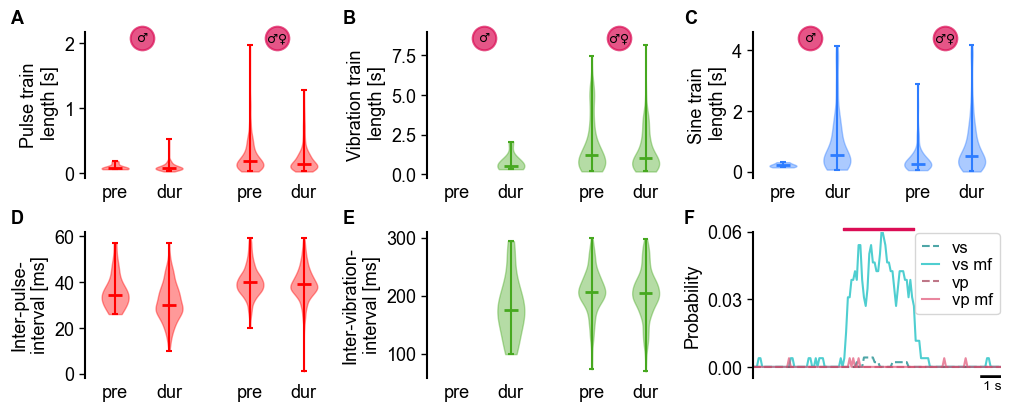

In [ ]:
# Set up a new figure
fig2, ax2 = plt.subplots(2, 3, figsize=(10,4))
ax2 = ax2.flatten()

# Plot the train lengths
myplt.violinplot([m_ptrains_pre, m_ptrains_dur, mf_ptrains_pre, mf_ptrains_dur], 
                 labels=["pre", "dur","pre", "dur"], 
                 positions=[1,2,3.5,4.5],
                 colors=pulse_col, 
                 ax=ax2[0], alpha=0.4, width=0.5)
myplt.violinplot([m_vtrains_pre, m_vtrains_dur, mf_vtrains_pre,mf_vtrains_dur], 
                 labels=["pre", "dur","pre", "dur"], 
                 positions=[1,2,3.5,4.5],
                 colors=vib_col, 
                 ax=ax2[1], alpha=0.4, width=0.5)
myplt.violinplot([m_strains_pre, m_strains_dur, mf_strains_pre, mf_strains_dur], 
                 labels=["pre", "dur","pre", "dur"], 
                 positions=[1,2,3.5,4.5],
                 colors=sine_col, 
                 ax=ax2[2], alpha=0.4, width=0.5)


# Set bottom spine invisible
ax2[0].spines["bottom"].set_visible(False)
ax2[0].tick_params(axis="x", length=0.0)
# Add condition pictograms
y_pos = ax2[0].get_ylim()[-1]
myplt.add_condition_pictogram(ax2[0], "m", x=1.5, y=y_pos, markersize=17, fontsize=9)
myplt.add_condition_pictogram(ax2[0], "mf", x=4, y=y_pos, markersize=17, fontsize=9)

# Set bottom spine invisible
ax2[1].spines["bottom"].set_visible(False)
ax2[1].tick_params(axis="x", length=0.0)
# Add condition pictograms
y_pos = ax2[1].get_ylim()[-1]
myplt.add_condition_pictogram(ax2[1], "m", x=1.5, y=y_pos, markersize=17, fontsize=9)
myplt.add_condition_pictogram(ax2[1], "mf", x=4, y=y_pos, markersize=17, fontsize=9)

# Set bottom spine invisible
ax2[2].spines["bottom"].set_visible(False)
ax2[2].tick_params(axis="x", length=0.0)
# Add condition pictograms
y_pos = ax2[2].get_ylim()[-1]
myplt.add_condition_pictogram(ax2[2], "m", x=1.5, y=y_pos, markersize=17, fontsize=9)
myplt.add_condition_pictogram(ax2[2], "mf", x=4, y=y_pos, markersize=17, fontsize=9)

# Label the plots
ax2[0].set_ylabel("Pulse train\n length [s]")
ax2[1].set_ylabel("Vibration train\n length [s]")
ax2[2].set_ylabel("Sine train\n length [s]")

ax2[0].set_title("A", x=-0.3)
ax2[1].set_title("B", x=-0.34)
ax2[2].set_title("C", x=-0.28)


# Plot the inter-pulse/vibration intervals
myplt.violinplot([pulse_times_pre, pulse_times_dur, pulse_times_mf_pre, pulse_times_mf_dur], 
                 labels=["pre", "dur","pre", "dur"], 
                 positions=[1,2,3.5,4.5],
                 colors=pulse_col, 
                 ax=ax2[3], alpha=0.4, width=0.5)

myplt.violinplot([vib_times_pre, vib_times_dur, vib_times_mf_pre, vib_times_mf_dur], 
                 labels=["pre", "dur","pre", "dur"], 
                 positions=[1,2,3.5,4.5],
                 colors=vib_col, 
                 ax=ax2[4], alpha=0.4, width=0.5)

# Plot the overlap probabilities over time
ax2[5].plot(time_vec, vs_overlap_prob, label="vs", color="#038082", linestyle="dashed", alpha=0.7)
ax2[5].plot(time_vec, vs_overlap_prob_mf, label="vs mf", color="#04BABD", alpha=0.7)

ax2[5].plot(time_vec, vp_overlap_prob, label="vp", color="#A33C54", linestyle="dashed", alpha=0.7)
ax2[5].plot(time_vec, vp_overlap_prob_mf, label="vp mf", color="#E05375", alpha=0.7)

ax2[5].legend(labelspacing=0.15)

ax2[5].set_ylim(bottom=-0.005, top=0.06)
ax2[5].set_yticks(np.linspace(0, round(ax2[5].get_ylim()[-1], 2), 3))

myplt.add_stim_bar(ax2[5], stim_period=[0,stim_len])
myplt.axis_to_scale(ax2[5], "s", 1, txt_offset=0.001)

# Set bottom spine invisible
ax2[3].spines["bottom"].set_visible(False)
ax2[3].tick_params(axis="x", length=0.0)
ax2[4].spines["bottom"].set_visible(False)
ax2[4].tick_params(axis="x", length=0.0)

ax2[3].set_ylabel("Inter-pulse-\ninterval [ms]")
ax2[4].set_ylabel("Inter-vibration-\ninterval [ms]")
ax2[5].set_ylabel("Probability")

ax2[3].set_title("D", x=-0.3)
ax2[4].set_title("E", x=-0.34)
ax2[5].set_title("F", x=-0.28)

# Save figure
fig2.savefig(f"../figures_wip/{exp_grp}/{exp_grp}_simple_song_stats.pdf")

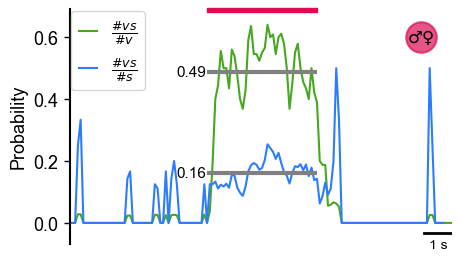

In [ ]:
# New figure
fig3, ax3 = plt.subplots(1, 1, figsize=(4.5,2.5))

# Plot the probabilities for sine-vibration overlap relative to either number of trials with vibrations or trials with sine
ax3.plot(time_vec, vs_overlap_mf_tovib, label=r'$\frac{\# vs}{\# v}$', color=vib_col)
ax3.plot(time_vec, vs_overlap_mf_tosine, label=r'$\frac{\# vs}{\# s}$', color=sine_col)

# Add lines and text for the mean values
ax3.hlines(vs_tovib_mean, 0, stim_len, color="gray", linewidth=3)
ax3.hlines(vs_tosine_mean, 0, stim_len, color="gray", linewidth=3)
ax3.text(-0.05, vs_tovib_mean, round(vs_tovib_mean, 2), ha="right", va="center", fontsize=11)
ax3.text(-0.05, vs_tosine_mean, round(vs_tosine_mean, 2), ha="right", va="center", fontsize=11)

# Legend and labels
ax3.legend(fontsize=13)
ax3.set_ylabel("Probability")
myplt.axis_to_scale(ax3, "s", txt_offset=0.02, linewidth=2)
myplt.add_stim_bar(ax3, stim_period=[0, stim_len])
myplt.add_condition_pictogram(ax3, "mf")

# Save figure
# ax3.set_ylim(top=0.69)
# fig3.savefig(f"../figures_wip/{exp_grp}/{exp_grp}_vs_overlap_detail.pdf")

### Plot an vibration-sine overlap example (TN1A)

In [9]:
# Load an example dataset 
example_dat, _ = dutils.load_dataset("E:/dat/localhost-20240419_095625/localhost-20240419_095625_daq.h5", filter=True, filter_chans=(1,10))

# Create suitable time vector
time_vec_example = np.arange(0, example_dat.shape[0]/sampling_rate, 1/sampling_rate)

# Select the annotations accordingly
annotations_example = annotations_mf[5]

# Create an index for a suitable time period
t_select = np.logical_and(time_vec_example > 320, time_vec_example <= 322)
# Subset the annotations and make the times relative to the selection
anno_tsel = annotations_example.loc[np.logical_and(annotations_example["start_seconds"] > 320, annotations_example["start_seconds"] <= 322)]
anno_tsel.loc[:, "start_seconds"] = anno_tsel.loc[:, "start_seconds"] - time_vec_example[t_select][0]
# Subset time vector for selected period
t_example = time_vec_example[t_select] - time_vec_example[t_select][0]
# Get stimulus start time in relative time
stim_start = t_example[time_vec_example[t_select] == 320.5][0]
# Select the data according to the selected time period
data = example_dat[t_select, 1]


## Perform a short time Fourier Transform of the audio signal to generate a spectrogram
# Set STFT parameters
win_len = 300
hop_len =  win_len // 2
nfft = 3 * win_len

# Compute STFT
spectrogrm = np.abs(librosa.stft(data, n_fft=nfft, hop_length=hop_len, win_length=win_len)) ** 2
# Log-compress the spectrogram to enhance the contrast
spec = np.log(1 + spectrogrm * 5) 
# Get the time and the frequency axis for the spectrogram
spec_t = librosa.frames_to_time(np.arange(spectrogrm.shape[1]), sr=sampling_rate, hop_length=hop_len, n_fft=nfft)
spec_f = librosa.fft_frequencies(sr=10000, n_fft=nfft)

# Create an index to select only relevant frequencies
freq_sel = np.logical_and(spec_f <= 800, spec_f > 50)

Loading file: E:/dat/localhost-20240419_095625/localhost-20240419_095625_daq.h5
Filtering channels 1 to 9


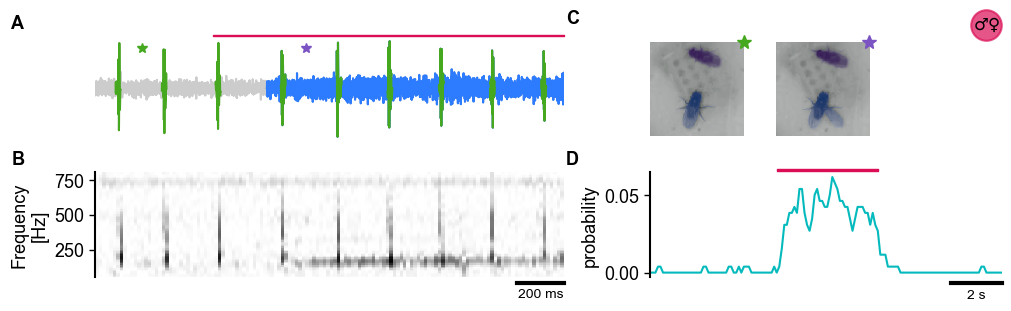

In [29]:
# Load the example pictures of the flies
pic_example = convert_from_path(f"../figures_wip/{exp_grp}/{exp_grp}_example_flies_colored.pdf")

# Set up a figure
fig3, ax3_dict = plt.subplot_mosaic([["A", "A", "A", "A", "C", "C", "C"],
                                     ["A", "A", "A", "A", "C", "C", "C"], 
                                     ["B", "B", "B", "B", "D", "D", "D"],
                                     ["B", "B", "B", "B", "D", "D", "D"]], figsize=(10,3), constrained_layout=False)

# Get axes handles
axa = ax3_dict["A"]
axb = ax3_dict["B"]
axc = ax3_dict["C"]
axd = ax3_dict["D"]


# Plot the whole example trace in the background
axa.plot(t_example, data, color='k', alpha=0.2)

# Create an index for the time during which there was sine
tsel = t_example >= anno_tsel.loc[anno_tsel["name"] == "sine_manual", "start_seconds"].to_numpy()[0]
# Plot the sine song
axa.plot(t_example[tsel], data[tsel], color=sine_col)

# Iterate over the vibration times
for vibt in anno_tsel.loc[anno_tsel["name"] == "vibration_manual", "start_seconds"]:
    # Create an index for the current vibration
    tsel = np.logical_and(t_example > vibt-0.005, t_example < vibt+0.015)
    # Plot the vibration 
    axa.plot(t_example[tsel], data[tsel], color=vib_col) 

# Add stars to indicate the time of the pictures in C
axa.plot(0.2, 0.1, '*', color=vib_col, markersize=7)
axa.plot(0.9, 0.1, '*', color="#7B53C2", markersize=7)


# Plot the spectrogram
pcm = axb.pcolormesh(spec_t, spec_f[freq_sel], spec[freq_sel, :], cmap="Grays")
# Get axes limits
axb_xmax = axb.get_xlim()[-1]
axb_ymin = axb.get_ylim()[0] - 40
axb_ylims = axb.get_ylim()
# Add a scale bar for the time axis
axb.plot([axb_xmax-0.2, axb_xmax], [axb_ymin, axb_ymin], color="k", linewidth=3, clip_on=False)
axb.text(axb_xmax-0.1, axb_ymin-40, "200 ms", color="k", horizontalalignment="center", verticalalignment="top", clip_on=False)

# Add a bar indicating the stimulation period
myplt.add_stim_bar(axa, [stim_start, t_example[-1]])


# Plot the example images
axc.imshow(pic_example[0], interpolation="none", origin="lower")
axc_ylims = axc.get_ylim()
# Add stars corresponding to the times in A
axc.plot(800, 800, '*', color=vib_col, clip_on=False)
axc.plot(1870, 800, '*', color="#7B53C2", clip_on=False)

# Plot the overlap probabilities
axd.plot(time_vec, vs_overlap_prob_mf, color="#04BABD", label="Vibration-Sine")
# Get axes limits
axd_xmax = axd.get_xlim()[-1]
axd_ylims = axd.get_ylim()
# Add a scale bar for the time axis
axd.plot([axd_xmax-2, axd_xmax], [axd_ylims[0]-0.0035, axd_ylims[0]-0.0035], color='k', linewidth=3, clip_on=False)
axd.text(axd_xmax-1, axd_ylims[0]-0.0075, "2 s", horizontalalignment="center", verticalalignment="top", clip_on=False)


# Add stimulation bars and pictograms
myplt.add_stim_bar(axd, stim_period=[0,stim_len])
myplt.add_condition_pictogram(axc, "mf", x=2870, y=950)

# Remove spines and tick values on x axis
axa.axis("off")
axc.axis("off")
axc.set_xlim((0, 3000))
axc.set_ylim(axc_ylims)

axb.spines["bottom"].set_visible(False)
axb.set_xticks([])
axb.set_ylim(axb_ylims)

axd.spines["bottom"].set_visible(False)
axd.set_xticks([])
axd.set_ylim(axd_ylims)

# Label the plots
axb.set_ylabel("Frequency\n[Hz]")
axd.set_ylabel("probability")
axa.set_title("A", x=-0.18)
axb.set_title("B", x=-0.18)
axc.set_title("C", x=-0.24, y=1.11)
axd.set_title("D", x=-0.24)

# Adjust subplot grid
plt.subplots_adjust(wspace=1.8, hspace=0.5, left=0.09, right=0.99, top=0.9, bottom=0.1)

# Save the figure
# fig3.savefig(f"E:/MT/figures_wip/{exp_grp}/{exp_grp}_overlap.pdf")